In [1]:
import nibabel as nib
import numpy as np
from os.path import join
import math
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp
# from statsmodels.stats.multitest import multipletests
from nilearn import plotting
from nilearn.image import resample_to_img

from scipy import ndimage
from scipy.spatial.distance import cdist
from scipy.sparse import csgraph
# import cvxpy as cp
from sklearn.model_selection import KFold
from itertools import product
import scipy.io as sio
import h5py
from sklearn.decomposition import PCA
import scipy.sparse as sp
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from scipy.stats import zscore

In [2]:
import psutil, os
p = psutil.Process(os.getpid())
p.cpu_affinity({20,21,22,23,24,25,26,27,28,29})   # use only core 0

Loading Datasets and Masks

In [2]:
import numpy as np
import nibabel as nib
from os.path import join

ses = 1
sub = '10'
run = 2

base_path = '/mnt/TeamShare/Data_Masterfile/H20-00572_All-Dressed/PRECISIONSTIM_PD_Data_Results/fMRI_preprocessed_data/Rev_pipeline/derivatives'

# # Load images without forcing full data into memory when not needed
# anat_path = f'{base_path}/sub-pd0{sub}/ses-{ses}/anat/sub-pd0{sub}_ses-{ses}_T1w_brain.nii.gz'
# anat_img = nib.load(anat_path) 
# print(anat_img.shape)

data_name = f'sub-pd0{sub}_ses-{ses}_run-{run}_task-mv_bold_corrected_smoothed_reg.nii.gz'
BOLD_path_org = join(base_path, f'sub-pd0{sub}', f'ses-{ses}', 'func', data_name)
bold_img = nib.load(BOLD_path_org)
bold_data = bold_img.get_fdata()

# mask_base = f'{base_path}/sub-pd0{sub}/ses-{ses}/anat'

# brain_mask_path = f'{mask_base}/sub-pd0{sub}_ses-{ses}_T1w_brain_mask.nii.gz'
# brain_mask_img = nib.load(brain_mask_path)
# back_mask = brain_mask_img.get_fdata()

# csf_path = f'{mask_base}/sub-pd0{sub}_ses-{ses}_T1w_brain_pve_0.nii.gz'
# csf_mask = nib.load(csf_path).get_fdata()

# wm_path = f'{mask_base}/sub-pd0{sub}_ses-{ses}_T1w_brain_pve_1.nii.gz'
# white_mask = nib.load(wm_path).get_fdata()

In [3]:
np.save(f'fmri_sub{sub}_ses{ses}_run{run}.npy', bold_data)

Apply Masks on Bold Dataset

In [3]:
back_mask_data = back_mask > 0
csf_mask_data = csf_mask > 0
white_mask_data = white_mask > 0.5
mask = np.logical_and(back_mask_data, ~csf_mask_data)
nonzero_mask = np.where(mask)

white_mask_flat = white_mask_data[nonzero_mask]
keep_voxels = ~white_mask_flat

bold_flat = bold_data[nonzero_mask]
masked_bold = bold_flat[keep_voxels]

masked_coords = tuple(ax[keep_voxels] for ax in nonzero_mask)

print(f"number of selected voxels after masking: {masked_bold.shape[0]/math.prod(bold_data.shape[:3])*100:.2f}%")
print('bold_data masked shape:', masked_bold.shape)

number of selected voxels after masking: 7.91%
bold_data masked shape: (619385, 850)


Plot voxels not in CSF and Background

In [5]:
# selected_mask = np.zeros(mask.shape, dtype=np.uint8)
# selected_mask[masked_coords] = 1
# selected_mask_img = nib.Nifti1Image(selected_mask, brain_mask_img.affine, brain_mask_img.header)

# view = plotting.view_img(
#     selected_mask_img,
#     bg_img=anat_img,
#     cmap='jet',
#     title='Selected voxels on anatomy',
# )
# view.save_as_html("Selected voxels on anatomy.html")

Remove voxels in CSF & brain mask from the bold data

In [4]:
num_trials = 90
trial_len = 9
masked_bold = masked_bold.astype(np.float32)
num_voxels, num_timepoints = masked_bold.shape
bold_data_reshape = np.full((num_voxels, num_trials, trial_len), np.nan, dtype=np.float32)

start = 0
for i in range(num_trials):
    end = start + trial_len
    if end > num_timepoints:
        raise ValueError("Masked BOLD data does not contain enough timepoints for all trials")
    bold_data_reshape[:, i, :] = masked_bold[:, start:end]
    start += trial_len
    if start in (270, 560):
        start += 20  # skip discarded timepoints

Load Beta values

In [5]:
glm_dict = np.load(f'TYPED_FITHRF_GLMDENOISE_RR_sub{sub}.npy', allow_pickle=True).item()
beta_glm = glm_dict['betasmd']
beta_run1, beta_run2 = beta_glm[:,0,0,:90], beta_glm[:,0,0,90:]

if run == 1:
    beta = beta_run1[keep_voxels]
else:
    beta = beta_run2[keep_voxels]
print("Beta Range:[", np.nanmin(beta), np.nanmax(beta), "], Mean: ", np.nanmean(beta))

Beta Range:[ -1854.696 19687.86 ], Mean:  0.00972046


check how many trials for each voxel have outlier beta (shows my previous method is incorrect)

In [8]:
# lower_thr, upper_thr = np.nanpercentile(beta, [1, 99])
# print(f'low_thr: {lower_thr:.2f}, high_thr: {upper_thr:.2f}') #low_thr: -4.64, high_thr: 4.60
# beta_extreme_mask = np.logical_or(beta < lower_thr, beta > upper_thr)
# voxels_with_extreme_beta = np.any(beta_extreme_mask, axis=1)

# print(f"percentage of voxels with extreme beta values: {np.sum(voxels_with_extreme_beta)/beta.shape[0]*100:.2f}%")

# mask = np.logical_and(back_mask_data, ~csf_mask_data)
# mask &= ~white_mask_data
# nonzero_mask = np.where(mask)

# clean_beta = beta[~voxels_with_extreme_beta]
# print('clean_beta shape:', clean_beta.shape)

# # This figure is related to my previous calculation (remove voxels even if they have one trial)
# tmp = np.sum(beta_extreme_mask[voxels_with_extreme_beta, :], axis=1)
# plt.hist(tmp)
# plt.xlabel('Num_trials')
# plt.ylabel("voxel count")
# plt.title('Trial-level Outlier Counts in Voxels with Extreme Beta')
# plt.show()

In [9]:
## Measure Mean and Var (Beta)
# fig, axs = plt.subplots(1,2)
# axs[0].hist(np.mean(beta, axis=1))
# axs[0].set_title('Mean')
# axs[1].hist(np.var(beta, axis=1))
# axs[1].set_title('Var')
# plt.suptitle('Original Beta')
# plt.tight_layout()
# plt.show()

Normalize beta value

In [6]:
# detect outlier beta after normalization
med = np.nanmedian(beta, keepdims=True)
mad = np.nanmedian(np.abs(beta - med), keepdims=True)
scale = 1.4826 * np.maximum(mad, 1e-9)    
beta_norm = (beta - med) / scale      
thr = np.nanpercentile(np.abs(beta_norm), 99.9)
outlier_mask = np.abs(beta_norm) > thr      
print(f"{np.sum(np.any(outlier_mask, axis=1))/beta.shape[0]*100:.2f}% voxels with at least one outlier beta")

4.09% voxels with at least one outlier beta


plot how many trials of each voxels are outlier

In [11]:
# data = np.sum(outlier_mask, axis=1)

# fig, ax = plt.subplots()
# ax.hist(data, bins=np.arange(data.min(), data.max() + 1), color="0.4")
# ax.set_xlabel("Num Trials")
# ax.set_ylabel("Num Voxels")

# axin = inset_axes(ax, width=1.2, height=1.2, bbox_to_anchor=(20, 300000), bbox_transform=ax.transData, loc='center', borderpad=1)
# axin.hist(data, bins=np.arange(10, 45), range=(10, 45), color="tab:orange")
# axin.set_xlim(10, 45)
# axin.tick_params(labelsize=7)
# axin.set_title("Range 10-45", fontsize=8)

# axin1 = inset_axes(ax, width=1.2, height=1.2, bbox_to_anchor=(60, 300000), bbox_transform=ax.transData, loc='center', borderpad=1)
# axin1.hist(data, bins=np.arange(45, 90), range=(45, 90), color="tab:red")
# axin1.set_xlim(45, 90)
# axin1.tick_params(labelsize=7)
# axin1.set_title("Range 45, 90", fontsize=8)

# fig.suptitle("Outlier trials counts for each voxels")
# plt.show()

NaN trials with extremely different beta values

In [7]:
clean_beta = beta.copy()
voxel_outlier_fraction = np.mean(outlier_mask, axis=1)
valid_voxels = voxel_outlier_fraction <= 0.5
clean_beta[~valid_voxels] = np.nan
clean_beta[np.logical_and(outlier_mask, valid_voxels[:, None])] = np.nan
keeped_mask = ~np.all(np.isnan(clean_beta), axis=1)
clean_beta = clean_beta[keeped_mask]
keeped_indices = np.flatnonzero(keeped_mask)

bold_data_reshape[~valid_voxels, :, :] = np.nan
# trial_outliers = np.logical_and(outlier_mask, valid_voxels[:, None])
# if np.any(trial_outliers):
#     vox_idx, trial_idx = np.where(trial_outliers)
#     bold_data_reshape[vox_idx, trial_idx, :] = np.nan
bold_data_reshape = bold_data_reshape[keeped_mask]

print(f"{(beta.shape[0]-clean_beta.shape[0])/beta.shape[0]*100}% of voxels have more than 50% outlier trials")
print('Clean BOLD reshape shape:', bold_data_reshape.shape)
print(f"Clean beta range: {np.nanmin(clean_beta):.2f}, {np.nanmax(clean_beta):.2f}")

0.02276451641547664% of voxels have more than 50% outlier trials
Clean BOLD reshape shape: (619244, 90, 9)
Clean beta range: -22.96, 22.97


Plot Beta and clean_beta on the brain

In [13]:
# # Collapse betas to single value per voxel (choose the summary you need)
# beta_summary = np.nanmean(beta, axis=1)
# clean_beta_summary = np.nanmean(clean_beta, axis=1)

# # Allocate full-brain volumes
# beta_map = np.full(bold_data.shape[:3], np.nan, dtype=np.float32)
# beta_map[masked_coords] = beta_summary

# clean_masked_coords = tuple(coord[keeped_mask] for coord in masked_coords)
# clean_beta_map = np.full(bold_data.shape[:3], np.nan, dtype=np.float32)
# clean_beta_map[clean_masked_coords] = clean_beta_summary

# beta_img_stat = nib.Nifti1Image(beta_map, bold_img.affine)
# clean_beta_img_stat = nib.Nifti1Image(clean_beta_map, bold_img.affine)

# beta_img_res = resample_to_img(beta_img_stat, anat_img, interpolation="linear")
# clean_beta_img_res = resample_to_img(clean_beta_img_stat, anat_img, interpolation="linear")

# finite_vals = clean_beta_map[np.isfinite(clean_beta_map)]
# vmin, vmax = finite_vals.min(), finite_vals.max()
# print(vmin, vmax)

# view = plotting.view_img(
#     beta_img_stat,
#     bg_img=anat_img,
#     threshold=0,
#     cmap='jet',
#     symmetric_cmap=False,
#     vmax=np.nanmax(beta_map),
#     vmin=-np.nanmin(beta_map),
#     title="Beta (mean across trials)",
# )

# view.save_as_html("Beta (mean across trials).html")

Plot beta and clean beta histogram

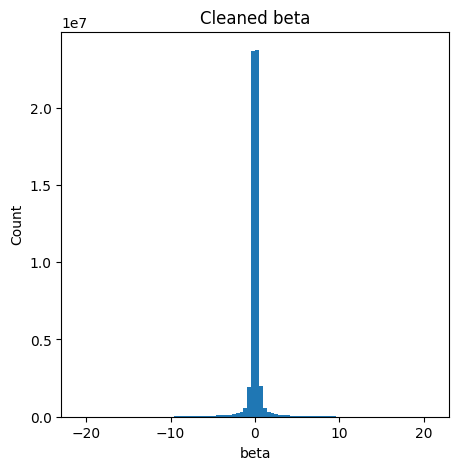

In [8]:
fig, ax = plt.subplots(figsize=(5, 5))
tmp = clean_beta.ravel()
ax.hist(tmp, density=False, bins=100)
ax.set_title('Cleaned beta')
ax.set_xlabel('beta')
ax.set_ylabel('Count')
ax.set_xlim(np.nanmin(tmp), np.nanmax(tmp))
ax.grid(False)

In [15]:
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches
# import numpy as np

# fig, ax = plt.subplots(figsize=(12, 7))
# tmp = beta.ravel()

# counts, bins, _ = ax.hist(tmp, bins=100, density=True, color='C0', alpha=0.85, edgecolor='none')
# ax.set_title('All beta')
# ax.set_xlabel('beta')
# ax.set_ylabel('density')

# ranges = [(-500,-20),(-1000,-500),(-2000,-1000), (100, 5000), (5000, 10000), (10000, 15000), (15000, 20000),(-20,20)]
# colors = ['C7','C6','C5','C1', 'C2', 'C3', 'C4','C8']
# positions = [
#     [0.3, 0.5, 0.1, 0.10],
#     [0.5, 0.5, 0.1, 0.10],
#     [0.8, 0.5, 0.1, 0.10],
#     [0.3, 0.2, 0.1, 0.10],
#     [0.3, 0.7, 0.1, 0.10],
#     [0.8, 0.2, 0.1, 0.10],
#     [0.8, 0.7, 0.1, 0.10],
#     [0.5, 0.2, 0.2, 0.20]
# ]

# ymax = counts.max()

# for (lo, hi), color, pos in zip(ranges, colors, positions):
#     # rect = patches.Rectangle((lo, 0), hi - lo, ymax, linewidth=1.5,
#     #                          edgecolor=color, facecolor='none', linestyle='--')
#     # ax.add_patch(rect)

#     axins = fig.add_axes(pos)
#     mask = (tmp >= lo) & (tmp < hi)
#     axins.hist(tmp[mask], bins=np.linspace(lo, hi, 20), density=True,
#                color=color, alpha=0.85, edgecolor='none')
#     axins.set_xlim(lo, hi)
#     # axins.set_ylim(0, ymax)
#     axins.set_title(f'{lo:.0f}–{hi:.0f}', fontsize=9)
#     axins.tick_params(axis='both', labelsize=7)
#     # axins.set_yticks([])

# fig.tight_layout()


Remove voxels with most of trials have bad beta value, interpolate rest of the beta

In [16]:
# # detect how many trials are bad for selected voxels
# beta_clean = beta.copy()
# trials = np.arange(beta.shape[1])
# voxel_outlier_fraction = np.sum(outlier_mask, axis=1)/outlier_mask.shape[1]*100
# valid_voxels = voxel_outlier_fraction <= 50
# beta_clean[~valid_voxels] = np.nan 

# # save the selected voxels indices for later
# keeped_voxels_mask = ~np.all(np.isnan(beta_clean), axis=1)
# keeped_voxels_indices = np.flatnonzero(keeped_voxels_mask)

# ## Measure Mean and Var (Beta)
# # fig, axs = plt.subplots(1,2)
# # axs[0].hist(np.mean(beta_clean, axis=1))
# # axs[0].set_title('Mean')
# # axs[1].hist(np.var(beta_clean, axis=1))
# # axs[1].set_title('Var')
# # plt.suptitle('After removing voxels (with 50% or higher trials with high beta)')
# # plt.tight_layout()
# # plt.show()

# # interpolate beta value for voxels which have less than 50% of trials as bad
# orig_outlier = []
# intrp_outlier = []
# for v in np.flatnonzero(valid_voxels):
#     mask = outlier_mask[v]
#     if not mask.any():
#         continue
#     good = ~mask
#     orig_outlier.append(beta[v, mask])
#     beta_clean[v, mask] = np.interp(trials[mask], trials[good], beta[v, good])
#     intrp_outlier.append(beta_clean[v, mask])

# # remove voxels that have more than 50% of trials bad beta value
# beta_clean1 = beta_clean[~np.all(np.isnan(beta_clean), axis=1)]
# print(f"{(beta_clean.shape[0]-beta_clean1.shape[0])/beta_clean.shape[0]*100:.3f}% voxels have more than 50% trials with outlier")
# clean_beta = beta_clean1
# clean_beta.shape

In [17]:
## Measure Mean and Var (Beta)
# fig, axs = plt.subplots(1,2)
# axs[0].hist(np.mean(clean_beta, axis=1))
# axs[0].set_title('Mean')
# axs[1].hist(np.var(clean_beta, axis=1))
# axs[1].set_title('Var')
# plt.suptitle('After Interpolation')
# plt.tight_layout()
# plt.show()

In [18]:
## Measure Skewness and Kurtosis
# from scipy.stats import skew
# from scipy.stats import kurtosis

# skew_value = skew(clean_beta, axis=1)
# kurt_value = kurtosis(clean_beta, axis=1)

# fig, axs = plt.subplots(1,2)
# axs[0].hist(skew_value)
# axs[0].set_title('Skewness')
# axs[1].hist(kurt_value)
# axs[1].set_title('kurtosis ')
# plt.suptitle('After Interpolation')
# plt.tight_layout()
# plt.show()

In [19]:
# #compare bold and beta variance 
# clean_bold = masked_bold[keeped_voxels_mask] 
# num_trials = 90
# trial_len = 9
# clean_bold_reshape = np.zeros((clean_bold.shape[0], num_trials, trial_len))
# start = 0

# for i in range(num_trials):
#         end = start + trial_len
#         clean_bold_reshape[:, i, :] = clean_bold[:, start:end]
#         start += trial_len
#         if start == 270 or start == 560:   # your skips
#             start += 20

# bold_var = np.mean(np.var(clean_bold_reshape, axis=1), axis=-1)
# beta_var = np.var(clean_beta, axis=-1)

# np.corrcoef(bold_var, beta_var)

Plot beta, clean_beta, interpolated beta

In [20]:
# def hist_with_zoom_ranges(x, fig_title, zoom_ranges, main_bins=200, inset_bins=60, density=False):
#     fig, ax = plt.subplots(figsize=(9,7))
#     ax.hist(x, bins=main_bins, density=density, color='C0', alpha=0.85, edgecolor='none')
#     ax.set_title(fig_title)
#     ax.set_xlabel('beta')
#     ax.set_ylabel('density' if density else 'count')

#     inset_data = []
#     for (lo, hi) in zoom_ranges:
#         xin = x[(x >= lo) & (x <= hi)]
#         counts, edges = np.histogram(xin, bins=inset_bins, range=(lo, hi), density=density)
#         inset_data.append((lo, hi, xin, edges, counts))

#     boxes = [(0.08, 0.08, 0.4, 0.34),
#              (0.2, 0.3, 0.4, 0.4),
#              (0.64, 0.08, 0.4, 0.34)]

#     for (left, bottom, w, h), (lo, hi, xin, edges, counts) in zip(boxes, inset_data):
#         axins = inset_axes(ax, width=f"{w*100:.0f}%", height=f"{h*100:.0f}%", bbox_to_anchor=(left, bottom, w, h), bbox_transform=ax.transAxes,
#             loc='upper left', borderpad=0.8)

#         if xin.size:
#             axins.hist(xin, bins=edges, density=density, color='C0', alpha=0.95, edgecolor='none')
#         else:
#             axins.text(0.5, 0.5, 'no data', ha='center', va='center', fontsize=8, transform=axins.transAxes)

#         axins.set_xlim(lo, hi)

#         if counts.size:
#             ymax = counts.max()
#             axins.set_ylim(0, ymax * 1.1)
#         else:
#             axins.set_ylim(0, 1)

#         axins.set_title(f"[{lo}, {hi}]", fontsize=9)
#         axins.tick_params(labelsize=8)

#         pp, p1, p2 = mark_inset(ax, axins, loc1=3, loc2=4, fc='none', ec='none')
#         pp.set_visible(False)
#         for con in (p1, p2):
#             con.set_color('0.4')
#             con.set_linewidth(1.2)

#     fig.tight_layout()
#     return fig, ax


# x = np.concatenate(orig_outlier)
# hist_with_zoom_ranges(x, 'Original Beta (for selected voxels)', ((-1500,-1000), (-100,100), (1000,2000)))
# plt.show()

# # x = np.concatenate(intrp_outlier)
# # hist_with_zoom_ranges(x, 'Interpolated Beta (for selected voxels)')
# # plt.show()

In [21]:
# before = np.concatenate(orig_outlier)     
# after  = np.concatenate(intrp_outlier)  

# n_bins = 200
# xmin, xmax = np.percentile(before, [0.1, 99.9])
# edges = np.linspace(xmin, xmax, n_bins + 1)
# b_counts, _ = np.histogram(before, bins=edges)
# a_counts, _ = np.histogram(after,   bins=edges)

# fig, axs = plt.subplots(1, 2, figsize=(15, 4), gridspec_kw={"wspace": 0.3})
# axs[0].hist(before, bins=edges, alpha=0.45, label='Before', color='C0')
# axs[0].hist(after,   bins=edges, alpha=0.45, label='After',  color='C1')
# axs[0].set_title('Beta bafore & after interpolation')
# axs[0].set_ylabel('count')
# axs[0].legend()

# centers = 0.5 * (edges[:-1] + edges[1:])
# delta = a_counts - b_counts
# axs[1].bar(centers, delta, width=np.diff(edges), align='center', color='C2', alpha=0.8)
# axs[1].axhline(0, color='0.3', lw=1)
# axs[1].set_title('Per-bin change (After − Before)')
# axs[1].set_xlabel('beta')
# axs[1].set_ylabel('Δ count')

# zoom_ranges = [(-800, -250), (250, 1000)]
# positions = [(0.1, 0.4, 0.5, 0.5),   
#              (0.6, 0.4, 0.5, 0.5)]   

# for (lo, hi), (lx, ly, lw, lh) in zip(zoom_ranges, positions):
#     axins = inset_axes(axs[1],
#                        width=f"{lw*100:.0f}%",
#                        height=f"{lh*100:.0f}%",
#                        bbox_to_anchor=(lx, ly, lw, lh),
#                        bbox_transform=axs[1].transAxes,
#                        loc='upper left',
#                        borderpad=0.8)
#     mask = (centers >= lo) & (centers <= hi)
#     axins.bar(centers[mask], delta[mask], width=np.diff(edges)[mask], align='center', color='C2', alpha=0.8)
#     axins.axhline(0, color='0.3', lw=1)
#     axins.set_xlim(lo, hi)
#     axins.set_title(f"[{lo},{hi}]", fontsize=8)
#     axins.tick_params(labelsize=7)

#     pp, p1, p2 = mark_inset(axs[1], axins, loc1=3, loc2=4, fc='none', ec='none')
#     pp.set_visible(False)
#     for con in (p1, p2):
#         con.set_color('0.4')
#         con.set_linewidth(1.2)

# plt.show()

In [22]:
# plt.figure()
# plt.hist(clean_beta.ravel())
# plt.xlabel("Beta")
# plt.ylabel("Count")

Plot outlier voxel on the brain

In [23]:
# extreme_volume = np.zeros(bold_img.shape[:3], dtype=np.float32)
# nonzero_mask_kept = tuple(axis[keep_voxels] for axis in nonzero_mask)

# extreme_volume[nonzero_mask_kept] = (~valid_voxels).astype(np.float32)
# extreme_img = nib.Nifti1Image(extreme_volume, bold_img.affine, bold_img.header)
# extreme_img = resample_to_img(extreme_img, anat_img, interpolation='nearest')
# view = plotting.view_img(extreme_img, bg_img=anat_img, cmap='autumn', symmetric_cmap=False, threshold=0.5, vmax=1, opacity=0.9, title='Voxels with Extreme Betas')
# view
# view.save_as_html(file_name=f'rejected_voxels_sub{sub}_ses{ses}_run{run}.html')

Apply t-test and FDR, detect & remove non-active voxels

In [9]:
# one sample t-test against 0
tvals, pvals = ttest_1samp(clean_beta, popmean=0, axis=1, nan_policy='omit')

# FDR correction
tested = np.isfinite(pvals)
alpha=0.05
rej, q, _, _ = multipletests(pvals[tested], alpha=alpha, method='fdr_bh')

n_voxel = clean_beta.shape[0]
qvals  = np.full(n_voxel, np.nan)
reject = np.zeros(n_voxel, dtype=bool)
reject[tested] = rej
qvals[tested]  = q

# reject non-active voxels
clean_active_beta = clean_beta[reject]
clean_active_idx = keeped_indices[reject]
clean_active_bold = bold_data_reshape[reject]
print('Active BOLD shape:', clean_active_bold.shape)
print(f"{clean_active_beta.shape[0]/clean_beta.shape[0]*100:.2f}% of voxels are active at FDR q<{alpha}")
clean_active_beta.shape

/home/zkavian/.venvs/workspace/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:634: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return result_to_tuple(hypotest_fun_out(*samples, **kwds), n_out)


Active BOLD shape: (315116, 90, 9)
50.89% of voxels are active at FDR q<0.05


(315116, 90)

Plot the beta hist again

In [25]:
# tmp = clean_active_beta.ravel()

# fig, ax = plt.subplots(figsize=(5, 5))
# ax.hist(tmp, density=True, bins=100)
# ax.set_title('Cleaned beta')
# ax.set_xlabel('beta')
# ax.set_ylabel('density')
# ax.set_xlim(np.nanmin(tmp), np.nanmax(tmp))

Create 3-D beta dataset to use it for filtering

In [10]:
num_trials = beta.shape[-1]
clean_active_volume = np.full(bold_data.shape[:3]+(num_trials,), np.nan)
active_coords = tuple(coord[clean_active_idx] for coord in masked_coords)
clean_active_volume[active_coords[0], active_coords[1], active_coords[2], :] = clean_active_beta
clean_active_volume.shape

(180, 256, 170, 90)

Map mean beta for active voxels back into anatomical space

In [27]:
# mean_beta_volume = np.nanmean(clean_active_volume, axis=-1)
# mean_beta_img = nib.Nifti1Image(mean_beta_volume, bold_img.affine, bold_img.header)
# # mean_beta_img = resample_to_img(mean_beta_img, anat_img, interpolation='linear')

# active_beta_view = plotting.view_img(mean_beta_img, bg_img=anat_img, cmap='jet', symmetric_cmap=False, threshold=1e-6, colorbar=True, title='Mean beta for active voxels')
# active_beta_view.save_as_html(file_name=f'active_beta_map.html')

Apply Hampel Filter to have smooth beta value (remove voxels that have 0-2 neighbour, smooth beta for voxles with more than 2 neighbour)

In [28]:
# def hampel_filter_image(image, window_size, threshold_factor, return_stats=False):
#     if window_size % 2 == 0:
#         raise ValueError("window_size must be odd")

#     filtered = image.astype(float).copy()
#     footprint = np.ones((window_size,) * 3, dtype=bool)

#     insufficient_counts = []
#     corrected_indices_parts = []

#     for t in range(image.shape[3]):
#         vol = image[..., t]
#         med = ndimage.generic_filter(vol, np.nanmedian, footprint=footprint, mode='constant', cval=np.nan)
#         mad = ndimage.generic_filter(np.abs(vol - med), np.nanmedian, footprint=footprint, mode='constant', cval=np.nan)
#         counts = ndimage.generic_filter(np.isfinite(vol).astype(np.float32), np.sum, footprint=footprint, mode='constant', cval=0)

#         scaled_mad = 1.4826 * mad
#         insufficient = counts < 3
#         insufficient_counts.append(int(np.count_nonzero(insufficient)))

#         filtered[..., t][insufficient] = np.nan

#         valid = np.isfinite(vol)
#         enough_data = (~insufficient) & valid
#         outliers = enough_data & (np.abs(vol - med) > threshold_factor * scaled_mad)

#         if np.any(outliers):
#             coords = np.argwhere(outliers)
#             t_column = np.full((coords.shape[0], 1), t, dtype=int)
#             corrected_indices_parts.append(np.hstack((coords, t_column)))

#         filtered[..., t][outliers] = med[outliers]

#     if return_stats:
#         insufficient_counts_arr = np.array(insufficient_counts, dtype=int)
#         if corrected_indices_parts:
#             corrected_indices = np.vstack(corrected_indices_parts)
#         else:
#             corrected_indices = np.empty((0, 4), dtype=int)

#         stats = {
#             'insufficient_counts': insufficient_counts_arr,
#             'insufficient_total': int(insufficient_counts_arr.sum()),
#             'corrected_indices': corrected_indices,
#             'corrected_total': int(corrected_indices.shape[0]),
#         }
#         return filtered, stats

#     return filtered


# beta_volume_filter, hampel_stats = hampel_filter_image(clean_active_volume, window_size=5, threshold_factor=3, return_stats=True)
# print('Insufficient neighbours per frame:', hampel_stats['insufficient_counts'], flush=True)
# print('Total voxels with <3 neighbours:', hampel_stats['insufficient_total'], flush=True)
# print('Total corrected voxels:', hampel_stats['corrected_total'], flush=True)
# if hampel_stats['corrected_total'] > 0:
#     preview = hampel_stats['corrected_indices'][:5]
#     print('Sample corrected voxel indices (x, y, z, t):', preview, flush=True)

# # save cleaned beta volume
# beta_volume_filter = beta_volume_filter[~np.all(np.isnan(beta_volume_filter), axis=-1)]
# np.save(f'cleaned_beta_volume_sub{sub}_ses{ses}_run{run}.npy', beta_volume_filter)


Load the filtered beta values

In [11]:
beta_valume_clean_2d = np.load(f'cleaned_beta_volume_sub{sub}_ses{ses}_run{run}.npy')
print(beta_valume_clean_2d.shape)
mask_2d = np.load("mask_all_nan_sub04_ses1_run1.npy")
np.sum(mask_2d)

(314734, 90)


np.int64(7518866)

plot beta hist again

In [30]:
# tmp = beta_valume_clean_2d.ravel()

# fig, ax = plt.subplots(figsize=(5, 5))
# ax.hist(tmp, density=True, bins=100)
# ax.set_title('Cleaned beta')
# ax.set_xlabel('beta')
# ax.set_ylabel('density')
# ax.set_xlim(np.nanmin(tmp), np.nanmax(tmp))

remove new voxels in the bold

In [12]:
active_flat_idx = np.ravel_multi_index(active_coords, clean_active_volume.shape[:3])
active_keep_mask = ~mask_2d[active_flat_idx]
clean_active_bold = clean_active_bold[active_keep_mask]
clean_active_bold.shape

(314734, 90, 9)

In [32]:
# # convert cleaned beta volume to a 2D array for optimization
# beta_volume_filter = np.load('beta_valume_clean_2d.npy')
# beta_volume_filter = beta_volume_filter.astype(np.float16)
# spatial_shape = beta_volume_filter.shape[:-1]
# voxels_with_any_nan = np.zeros(spatial_shape, dtype=bool)
# voxels_with_all_nan = np.ones(spatial_shape, dtype=bool)

# # Sweep the time dimension once
# for t in range(beta_volume_filter.shape[-1]):
#     frame_nan = np.isnan(beta_volume_filter[..., t])
#     voxels_with_any_nan |= frame_nan
#     voxels_with_all_nan &= frame_nan

# print(np.sum(voxels_with_any_nan), np.sum(voxels_with_all_nan), flush=True)

# n_trial = beta_volume_filter.shape[-1]
# beta_volume_filter_2d = beta_volume_filter.reshape(-1, n_trial)
# print(beta_volume_filter_2d.shape, flush=True)
# mask_2d = voxels_with_all_nan.reshape(-1)
# beta_valume_clean_2d = beta_volume_filter_2d[~mask_2d]
# print(beta_valume_clean_2d.shape, flush=True)
# np.save(f'beta_valume_clean_2d.npy', beta_valume_clean_2d)

In [33]:
# del anat_img, back_mask, csf_mask, white_mask, mask, nonzero_mask, masked_bold
# del beta_run1, beta_run2, beta, clean_beta, voxels_with_all_nan, voxels_with_any_nan
# del beta_volume_filter_2d, beta_valume_clean_2d

Plot finall beta value on the brain

In [34]:
# mask_2d = np.load("mask_all_nan_sub04_ses1_run1.npy")
# active_flat = np.ravel_multi_index(active_coords, clean_active_volume.shape[:3])
# keep_mask = ~mask_2d[active_flat]                 # length = 315116 → 314734 True
# filtered_coords = tuple(c[keep_mask] for c in active_coords)

# beta_volume = np.full(bold_data.shape[:3] + (beta_valume_clean_2d.shape[1],), np.nan, np.float32)
# beta_volume[filtered_coords[0], filtered_coords[1], filtered_coords[2], :] = beta_valume_clean_2d.astype(np.float32)
# beta_map = np.nanmean(beta_volume, axis=3)
# beta_img = nib.Nifti1Image(np.abs(beta_map), bold_img.affine, bold_img.header)
# view = plotting.view_img(beta_img, bg_img=anat_img, threshold=0.0, cmap="jet", symmetric_cmap=False)
# view.save_as_html(file_name=f'final_beta.html')


Load the clean beta, which is ready for optimization problem

In [35]:
# beta_valume_clean_2d = np.load(f'beta_valume_clean_2d.npy')
# beta_valume_clean_2d.shape

Create Matrices for Optim problem

In [36]:
# def calculate_matrices(
#     beta_valume_clean_2d,
#     bold_data,
#     mask_2d,
#     trial_indices=None,
#     trial_len=9,
#     num_components=600,
#     pca_components=None,
#     pca_mean=None):
#     print("begin", flush=True)
#     print(type(mask_2d))
#     num_trials = beta_valume_clean_2d.shape[-1]
#     trial_idx = np.arange(num_trials) if trial_indices is None else np.unique(np.asarray(trial_indices, int).ravel())

#     # ----- reshape BOLD into trials -----
#     bold_data_reshape = bold_data.reshape(-1, bold_data.shape[-1])
#     print(bold_data.reshape(-1, bold_data.shape[-1]).shape[0], mask_2d.dtype, mask_2d.size)
#     bold_data_selected = bold_data_reshape[~mask_2d]         # keep voxels of interest
#     bold_data_selected_reshape = np.zeros((bold_data_selected.shape[0], num_trials, trial_len), dtype=np.float32)
#     start = 0
    
#     for i in range(num_trials):
#         end = start + trial_len
#         if end > bold_data_selected.shape[1]:
#             raise ValueError("BOLD data does not contain enough timepoints for all trials")
#         bold_data_selected_reshape[:, i, :] = bold_data_selected[:, start:end]
#         start += trial_len
#         if start == 270 or start == 560:   # your skips
#             start += 20
#     X = bold_data_selected_reshape[:, trial_idx, :]          # [Nvox, Ntrials, T]
#     print("BOLD reshaped before PCA", X.shape, flush=True)

#     # ----- apply PCA -----
#     print("PCA...", flush=True)
#     X_reshap = X.reshape(X.shape[0], -1).astype(np.float32)

#     if pca_components is None or pca_mean is None:
#         pca = PCA()
#         X_pca_full = pca.fit_transform(X_reshap.T).astype(np.float32)
#         components = pca.components_.astype(np.float32)
#         mean = pca.mean_.astype(np.float32)
#         n_components = min(num_components, components.shape[0])
#         components = components[:n_components]
#         X_pca = X_pca_full[:, :n_components]
#     else:
#         components = pca_components.astype(np.float32)
#         mean = pca_mean.astype(np.float32)
#         n_components = components.shape[0]
#         X_centered = X_reshap.T - mean
#         X_pca = (X_centered @ components.T).astype(np.float32)

#     beta_reduced = (beta_valume_clean_2d.T - mean) @ components.T
#     beta_reduced = beta_reduced.T


#     # ----- L_task (same idea as yours) -----
#     print("L_task...", flush=True)
#     beta_selected = beta_reduced[:, trial_idx]
#     counts = np.count_nonzero(np.isfinite(beta_selected), axis=-1)
#     sums = np.nansum(beta_selected, axis=-1, dtype=np.float64)
#     mean_beta = np.zeros(beta_selected.shape[0], dtype=np.float32)
#     m = counts > 0
#     mean_beta[m] = np.abs((sums[m] / counts[m])).astype(np.float32)
#     L_task = np.zeros_like(mean_beta, dtype=np.float32)
#     v = np.abs(mean_beta) > 0
#     L_task[v] = (1.0 / mean_beta[v]).astype(np.float32)

#     # ----- L_var_bold: variance of trial differences, as sparse diagonal -----
#     print("L_var...", flush=True)
#     X_pca = X_pca[:, :n_components].T
#     num_trials = len(trial_idx)
#     X = X_pca.reshape(X_pca.shape[0], num_trials, trial_len)
#     L_var_bold = np.zeros((X.shape[0], X.shape[0]), dtype=np.float32)
#     for i in range(num_trials-1):
#         x1 = X[:, i, :]
#         x2 = X[:, i+1, :]
#         L_var_bold += (x1-x2) @ (x1-x2).T
#     L_var_bold /= (num_trials - 1)

#     # ----- L_var_beta: variance of trial differences, as sparse diagonal -----
#     print("L_var...", flush=True)
#     num_trials = len(trial_idx)
#     X = beta_reduced
#     L_var_beta = np.zeros((X.shape[0], X.shape[0]), dtype=np.float32)
#     for i in range(num_trials-1):
#         x1 = X[:, i]
#         x2 = X[:, i+1]
#         L_var_bold += (x1-x2) @ (x1-x2).T
#     L_var_beta /= (num_trials - 1)

#     selected_BOLD_flat = X.reshape(X.shape[0], -1).astype(np.float32)
#     return L_task.astype(np.float32), L_var, L_var_beta, selected_BOLD_flat, components, mean

# # %%
# def objective_func(w, L_task, L_var_bold, L_var_beta, alpha_var_bold, alpha_var_beta):
#     print("Calculating objective...", flush=True)
#     L_task = zscore(L_task)
#     L_var_bold = zscore(L_var_bold)
#     L_var_beta = zscore(L_var_beta)
#     quad = (w.T @ np.diag(L_task) @ w + alpha_var_bold * (w.T @ L_var_bold @ w) + alpha_var_beta * (w.T @ L_var_beta @ w))
#     return quad

# # %%
# def optimize_voxel_weights(L_task, L_var, alpha_var):
#     print("Optimizing voxel weights...", flush=True)
#     L_total = np.diag(L_task) + alpha_var * L_var
#     n = L_total.shape[0]
#     L_total = np.nan_to_num(L_total)
#     L_total = 0.5*(L_total + L_total.T) + 1e-6*np.eye(n)
#     eigvals, eigvecs = np.linalg.eigh(L_total)
#     eigvals[eigvals < 0] = 0.0  # clip the numerical negatives
#     L_total_psd = (eigvecs @ np.diag(eigvals) @ eigvecs.T).astype(np.float64)

#     w = cp.Variable(n, nonneg=True)
#     constraints = [cp.sum(w) == 1]

#     objective = cp.Minimize(cp.quad_form(w, cp.psd_wrap(L_total_psd)))
#     problem = cp.Problem(objective, constraints)
#     problem.solve(solver=cp.OSQP, verbose=True)
#     return w.value


# # %%
# def calculate_weight(param_grid, beta_valume_clean_2d, bold_data, mask_2d, trial_len):
#     kf = KFold(n_splits=5, shuffle=True, random_state=0)
#     best_score = np.inf
#     best_alpha_var = None
#     num_trials = beta_valume_clean_2d.shape[-1]

#     for a_var_bold in param_grid["alpha_var"]:
#         fold_scores = []
#         print(f"a_var: {a_var_bold}", flush=True)
#         count = 1

#         for train_idx, val_idx in kf.split(np.arange(num_trials)):
#             print(f"k-fold num: {count}", flush=True)
#             print(type(mask_2d), flush=True)
#             L_task_train, L_var_bold_train, L_var_beta_train, _, pca_components, pca_mean = calculate_matrices(
#                 beta_valume_clean_2d,
#                 bold_data,
#                 mask_2d,
#                 train_idx,
#                 trial_len,
#             )
#             w = optimize_voxel_weights(L_task_train, L_var_train, alpha_var=a_var_bold)

#             L_task_val, L_var_bold_val, L_var_beta_val, _, _, _ = calculate_matrices(
#                 beta_valume_clean_2d,
#                 bold_data,
#                 mask_2d,
#                 val_idx,
#                 trial_len,
#                 pca_components=pca_components,
#                 pca_mean=pca_mean,
#             )

#             fold_scores.append(objective_func(w, L_task_val, L_var_bold_val, L_var_beta_val, a_var_bold, alpha_var_beta))
#             print(f"fold_scores: {fold_scores}", flush=True)
#             count += 1

#         mean_score = np.mean(fold_scores)
#         print(mean_score)
#         if mean_score < best_score:
#             best_score = mean_score
#             best_alpha_var = a_var_bold

#     print("Best alpha_var:", best_alpha_var, "with CV loss:", best_score, flush=True)
#     return best_alpha_var, best_score

In [13]:
def calculate_matrices(beta_valume_clean_2d, bold_data, mask_2d, trial_indices=None, trial_len=9, num_components=600, pca_components=None, pca_mean=None):
    print("begin", flush=True)
    print(type(mask_2d))
    num_trials = beta_valume_clean_2d.shape[-1]
    trial_idx = np.arange(num_trials) if trial_indices is None else np.unique(np.asarray(trial_indices, int).ravel())

    # ----- reshape BOLD into trials -----
    bold_data_reshape = bold_data.reshape(-1, bold_data.shape[-1])
    print(bold_data.reshape(-1, bold_data.shape[-1]).shape[0], mask_2d.dtype, mask_2d.size)
    bold_data_selected = bold_data_reshape[~mask_2d]         # keep voxels of interest
    bold_data_selected_reshape = np.zeros((bold_data_selected.shape[0], num_trials, trial_len), dtype=np.float32)
    start = 0
    
    for i in range(num_trials):
        end = start + trial_len
        if end > bold_data_selected.shape[1]:
            raise ValueError("BOLD data does not contain enough timepoints for all trials")
        bold_data_selected_reshape[:, i, :] = bold_data_selected[:, start:end]
        start += trial_len
        if start == 270 or start == 560:   # your skips
            start += 20
    X = bold_data_selected_reshape[:, trial_idx, :]          # [Nvox, Ntrials, T]
    print("BOLD reshaped before PCA", X.shape, flush=True)

    # ----- apply PCA -----
    print("PCA...", flush=True)
    X_reshap = X.reshape(X.shape[0], -1).astype(np.float32)

    if pca_components is None or pca_mean is None:
        print(1)
        pca = PCA()
        X_pca_full = pca.fit_transform(X_reshap.T).astype(np.float32)
        components = pca.components_.astype(np.float32)
        mean = pca.mean_.astype(np.float32)
        n_components = min(num_components, components.shape[0])
        components = components[:n_components]
        X_pca = X_pca_full[:, :n_components]
    else:
        print(2)
        components = pca_components.astype(np.float32)
        mean = pca_mean.astype(np.float32)
        n_components = components.shape[0]
        X_centered = X_reshap.T - mean
        X_pca = (X_centered @ components.T).astype(np.float32)

    print(beta_valume_clean_2d.shape)
    print(components.shape)
    beta_reduced = (beta_valume_clean_2d.T - mean) @ components.T
    beta_reduced = beta_reduced.T


    # ----- L_task (same idea as yours) -----
    print("L_task...", flush=True)
    beta_selected = beta_reduced[:, trial_idx]
    counts = np.count_nonzero(np.isfinite(beta_selected), axis=-1)
    sums = np.nansum(np.abs(beta_selected), axis=-1, dtype=np.float64)
    mean_beta = np.zeros(beta_selected.shape[0], dtype=np.float32)
    m = counts > 0
    mean_beta[m] = (sums[m] / counts[m]).astype(np.float32)
    L_task = np.zeros_like(mean_beta, dtype=np.float32)
    v = np.abs(mean_beta) > 0
    L_task[v] = (1.0 / mean_beta[v]).astype(np.float32)

    # ----- L_var_bold: variance of trial differences, as sparse diagonal -----
    print("L_var...", flush=True)
    X_pca = X_pca[:, :n_components].T
    num_trials = len(trial_idx)
    X = X_pca.reshape(X_pca.shape[0], num_trials, trial_len)
    L_var_bold = np.zeros((X.shape[0], X.shape[0]), dtype=np.float32)
    for i in range(num_trials-1):
        x1 = X[:, i, :]
        x2 = X[:, i+1, :]
        L_var_bold += (x1-x2) @ (x1-x2).T
    L_var_bold /= (num_trials - 1)

    # ----- L_var_beta: variance of trial differences, as sparse diagonal -----
    print("L_var...", flush=True)
    num_trials = len(trial_idx)
    X = beta_reduced
    L_var_beta = np.zeros((X.shape[0], X.shape[0]), dtype=np.float32)
    for i in range(num_trials-1):
        x1 = X[:, i]
        x2 = X[:, i+1]
        L_var_bold += (x1-x2) @ (x1-x2).T
    L_var_beta /= (num_trials - 1)

    selected_BOLD_flat = X.reshape(X.shape[0], -1).astype(np.float32)
    return L_task.astype(np.float32), L_var_beta, L_var_beta, selected_BOLD_flat, components, mean

# %%
def objective_func(w, L_task, L_var_bold, L_var_beta, alpha_var_bold, alpha_var_beta):
    print("Calculating objective...", flush=True)
    def _safe_scale(arr):
        scale = np.max(np.abs(arr))
        if not np.isfinite(scale) or scale <= 0:
            scale = 1.0
        print(f"scale: {scale}")
        return arr / scale

    L_task_scaled = _safe_scale(L_task)
    L_var_bold_scaled = _safe_scale(L_var_bold)
    L_var_beta_scaled = _safe_scale(L_var_beta)

    quad = (w.T @ np.diag(L_task_scaled) @ w + alpha_var_bold * (w.T @ L_var_bold_scaled @ w) + 
            alpha_var_beta * (w.T @ L_var_beta_scaled @ w))
    return quad

# %%
def optimize_voxel_weights(L_task, L_var_bold, L_var_beta, alpha_var_bold, alpha_var_beta):
    print("Optimizing voxel weights...", flush=True)
    def _safe_scale(arr):
        scale = np.max(np.abs(arr))
        print(scale)
        if not np.isfinite(scale) or scale <= 0:
            scale = 1.0
        print(f"scale: {scale}")
        return arr / scale

    L_task_scaled = _safe_scale(L_task)
    L_var_bold_scaled = _safe_scale(L_var_bold)
    L_var_beta_scaled = _safe_scale(L_var_beta)

    L_total = (np.diag(L_task_scaled) + alpha_var_bold * L_var_bold_scaled + alpha_var_beta * L_var_beta_scaled)
    L_total = np.nan_to_num(L_total, copy=False).astype(np.float64, copy=False)
    L_total = 0.5 * (L_total + L_total.T)
    L_total += 1e-8 * np.eye(L_total.shape[0])

    w = cp.Variable(L_total.shape[0], nonneg=True)
    constraints = [cp.sum(w) == 1]

    objective = cp.Minimize(cp.quad_form(w, cp.psd_wrap(L_total)))
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.OSQP, verbose=True)
    return w.value


# %%
def calculate_weight(param_grid, beta_valume_clean_2d, bold_data, mask_2d, trial_len):
    kf = KFold(n_splits=2, shuffle=True, random_state=42)
    best_score = np.inf
    best_alpha_var_bold = None
    best_alpha_var_beta = None
    num_trials = beta_valume_clean_2d.shape[-1]

    for alpha_var_bold, alpha_var_beta in product(param_grid["alpha_var_bold"], param_grid["alpha_var_beta"]):
        fold_scores = []
        print(f"a_var: {alpha_var_bold}, {alpha_var_beta}", flush=True)
        count = 1

        for train_idx, val_idx in kf.split(np.arange(num_trials)):
            print(f"k-fold num: {count}", flush=True)
            # print(type(mask_2d), flush=True)
            # print(f"11: {beta_valume_clean_2d.shape}")
            L_task_train, L_var_bold_train, L_var_beta_train, _, pca_components, pca_mean = calculate_matrices(
                beta_valume_clean_2d, bold_data, mask_2d, train_idx, trial_len)
            w = optimize_voxel_weights(L_task_train, L_var_bold_train, L_var_beta_train, alpha_var_bold, alpha_var_beta)

            L_task_val, L_var_bold_val, L_var_beta_val, _, _, _ = calculate_matrices(beta_valume_clean_2d, bold_data, 
            mask_2d, val_idx, trial_len, pca_components=pca_components, pca_mean=pca_mean)

            fold_scores.append(objective_func(w, L_task_val, L_var_bold_val, L_var_beta_val, alpha_var_bold, alpha_var_beta))
            print(f"fold_scores: {fold_scores}", flush=True)
            count += 1

        mean_score = np.mean(fold_scores)
        print(mean_score)
        if mean_score < best_score:
            best_score = mean_score
            best_alpha_var_bold = alpha_var_bold
            best_alpha_var_beta = alpha_var_beta

    print("Best alpha_var_bold:", best_alpha_var_bold, "Best alpha_var_beta:", best_alpha_var_beta, "with CV loss:", best_score, flush=True)
    return alpha_var_bold, alpha_var_beta, best_score


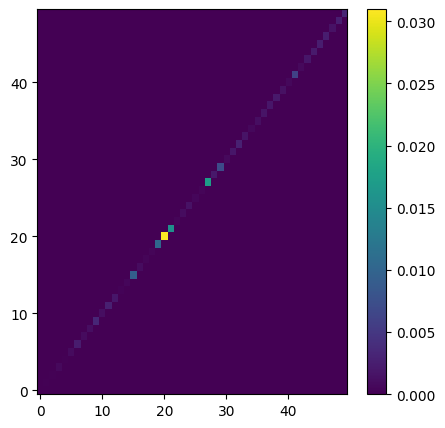

In [54]:
tmp = np.diag(L_task/np.max(L_task))

fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(tmp[:50, :50], aspect='auto', cmap='viridis')
ax.invert_yaxis()
fig.colorbar(im, ax=ax)

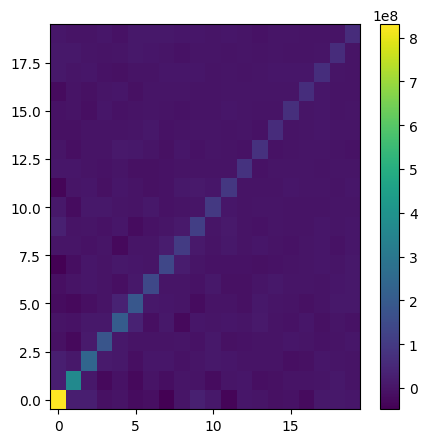

In [36]:
fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(L_var_bold[:20, :20], aspect='auto', cmap='viridis')
ax.invert_yaxis()
fig.colorbar(im, ax=ax)

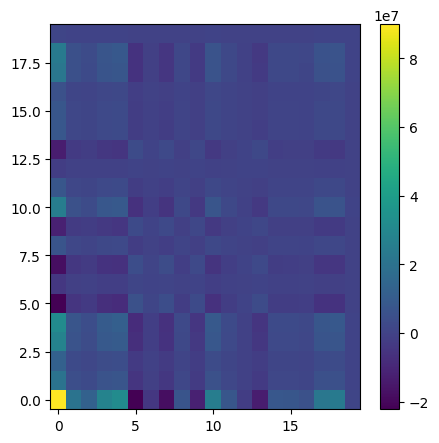

In [37]:
fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(L_var_beta[:20, :20], aspect='auto', cmap='viridis')
ax.invert_yaxis()
fig.colorbar(im, ax=ax)

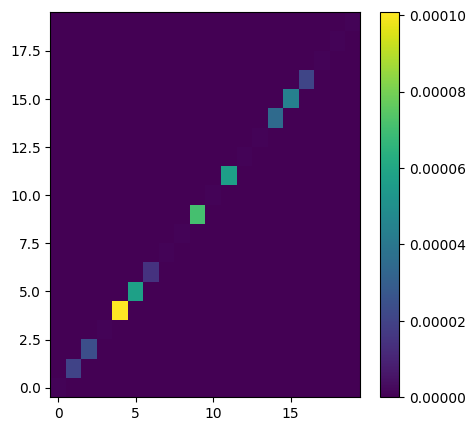

In [78]:
tmp = np.diag(L_behavior)

fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(tmp[:20, :20], aspect='auto', cmap='viridis')
ax.invert_yaxis()
fig.colorbar(im, ax=ax)

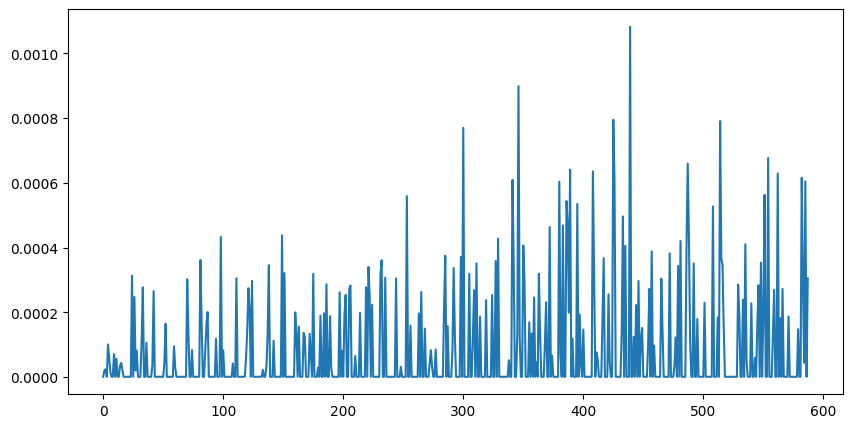

In [77]:
plt.figure(figsize=(10, 5))
plt.plot(L_behavior)

Analysis the Optim Output

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
s1, s2 = 0.05, 10
L_task = np.load('results/L_task.npy') # (588,)
L_var_beta = np.load('results/L_var_beta.npy') # (588,588)
L_var_bold = np.load('results/L_var_bold.npy') # (588,588)
# voxel_space_weights = np.load(f'results/{s1}_{s2}_voxel_space_weights.npy') #(314734,)
# # weights = np.load(f'results/{s1}_{s2}_weights.npy') # (588,)
# y = np.load(f'results/{s1}_{s2}_y.npy') #(810)
# y.shape

In [ ]:
import numpy as np
data = np.load('/home/zkavian/Thesis_code_Glm_Opt/objective_eigenvalue_sub04_ses1_run1.npy')
data.shape

In [ ]:
import seaborn as sns
sns.set_theme(style="whitegrid")

# --- Task loss line plot ---
fig_task, ax_task = plt.subplots(figsize=(6, 4))
sns.lineplot(x=np.arange(L_task.shape[0]), y=L_task / np.max(L_task), ax=ax_task, color="steelblue")
ax_task.set(xlabel="Index", ylabel="L_task", title="Task Loss")
fig_task.tight_layout()
plt.show()

# --- L_var_beta heatmap ---
from matplotlib import colors

tmp = L_var_beta / np.max(L_var_beta)
mask = np.isclose(tmp, 1.0)

fig, axes = plt.subplots(1, 3, figsize=(12, 5))
ranges = [(0, 100), (100, 300), (300, 600)]

for ax, (start, end) in zip(axes, ranges):
    data = tmp[start:end, start:end]
    data_mask = mask[start:end, start:end]
    sns.heatmap(data, ax=ax, cmap="jet", cbar=ax)
    ax.set(xlabel="component", ylabel="component", title=f"L_var_beta ({start}–{end})")
    ax.invert_yaxis()

    tick_idx = np.linspace(0, data.shape[0] - 1, 5, dtype=int)
    tick_labels = np.linspace(start, end, 5, dtype=int)
    ax.set_xticks(tick_idx)
    ax.set_xticklabels(tick_labels)
    ax.set_yticks(tick_idx)
    ax.set_yticklabels(tick_labels)

fig.tight_layout()
plt.show()



# --- L_var_bold heatmap ---
tmp = L_var_bold / np.max(L_var_bold)
mask = np.isclose(tmp, 1.0)

fig, axes = plt.subplots(1, 3, figsize=(12, 5))
ranges = [(0, 10), (10, 20), (20, 30)]

for ax, (start, end) in zip(axes, ranges):
    data = tmp[start:end, start:end]
    data_mask = mask[start:end, start:end]
    sns.heatmap(data, ax=ax, cmap="jet", cbar=ax)
    ax.set(xlabel="component", ylabel="component", title=f"L_var_bold ({start}–{end})")
    ax.invert_yaxis()

    tick_idx = np.linspace(0, data.shape[0] - 1, 5, dtype=int)
    tick_labels = np.linspace(start, end, 5, dtype=int)
    ax.set_xticks(tick_idx)
    ax.set_xticklabels(tick_labels)
    ax.set_yticks(tick_idx)
    ax.set_yticklabels(tick_labels)

fig.tight_layout()
plt.show()


In [ ]:
fig_hist, hist_axes = plt.subplots(1, 3, figsize=(18, 4))

sns.histplot(L_task/np.max(L_task), bins=30, ax=hist_axes[0], color="steelblue")
hist_axes[0].set(xlabel="L_task", ylabel="Count", title="L_task Distribution")
hist_axes[0].set_yscale("log")

sns.histplot(L_var_beta.ravel()/np.max(L_var_beta), bins=30, ax=hist_axes[1], color="seagreen")
hist_axes[1].set(xlabel="Value", ylabel="Count", title="L_var_beta Distribution")
hist_axes[1].set_yscale("log")

sns.histplot(L_var_bold.ravel()/np.max(L_var_bold), bins=30, ax=hist_axes[2], color="darkmagenta")
hist_axes[2].set(xlabel="Value", ylabel="Count", title="L_var_bold Distribution")
hist_axes[2].set_yscale("log")

plt.tight_layout()
plt.show()

In [116]:
s1, s2, s3 = 0.05, 0.05, 0.05
voxel_space_weights = np.load(f'results_regressors/{s1}_{s2}_{s3}_voxel_space_weights.npy') #(314734,)
weights = np.load(f'results_regressors/{s1}_{s2}_{s3}_weights.npy') # (588,)
y = np.load(f'results_regressors/{s1}_{s2}_{s3}_y.npy') #(810)

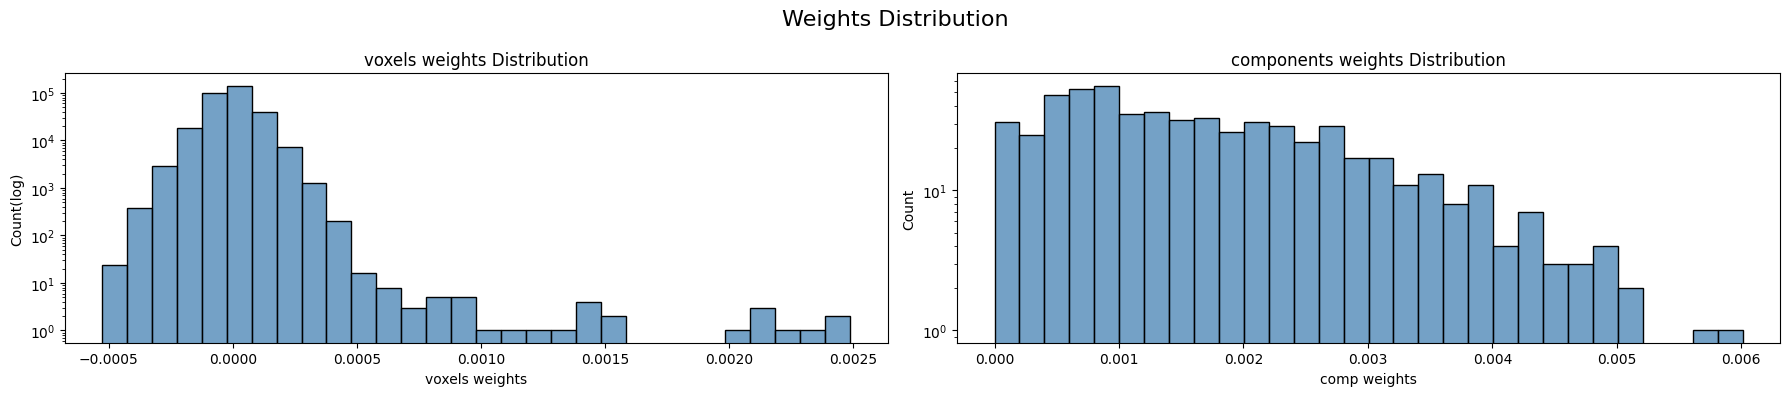

In [117]:
fig_hist, hist_axes = plt.subplots(1, 2, figsize=(18, 4))

sns.histplot(voxel_space_weights, bins=30, ax=hist_axes[0], color="steelblue")
hist_axes[0].set(xlabel="voxels weights", ylabel="Count(log)", title="voxels weights Distribution")
hist_axes[0].set_yscale("log")

sns.histplot(weights, bins=30, ax=hist_axes[1], color="steelblue")
hist_axes[1].set(xlabel="comp weights", ylabel="Count", title="components weights Distribution")
hist_axes[1].set_yscale("log")

plt.suptitle("Weights Distribution", fontsize=16)
plt.tight_layout()

Text(0.5, 1.0, 'reconstructed Y')

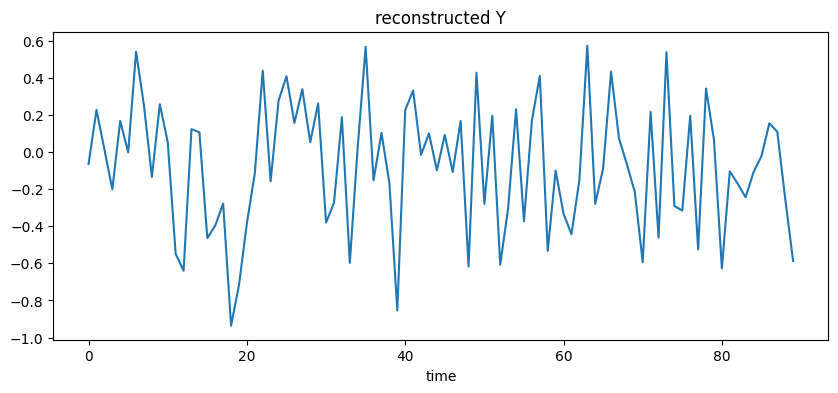

In [118]:
plt.figure(figsize=(10, 4))
plt.plot(y)
plt.xlabel("time")
plt.title("reconstructed Y")

In [119]:
weight_vol = np.zeros(bold_data.shape[:3], dtype=np.float32)
active_coords_kept = tuple(coord[active_keep_mask] for coord in active_coords)
weight_vol[active_coords_kept] = np.abs(voxel_space_weights)

# lowe, upper = 0.0004, 0.002
# mask = (weight_vol >= lowe) & (weight_vol <= upper)
# weight_vol = np.where(mask, weight_vol, np.nan)
weight_vol = np.clip(weight_vol, None, 0.0004)

weight_img = nib.Nifti1Image(weight_vol, bold_img.affine)
weight_img_resamp = resample_to_img(weight_img, anat_img, interpolation="continuous")

view = plotting.view_img(
    weight_img_resamp,
    bg_img=anat_img,
    # threshold=np.percentile(voxel_space_weights, 95),
    # threshold=0.0,
    symmetric_cmap=False,
    cmap="jet",
    draw_cross=False,
    colorbar=True,
)
view.save_as_html(file_name=f'weights_map_{s1}_{s2}_{s3}regressor_scale_shuffle.html')

/tmp/ipykernel_2433833/648601424.py:11: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  weight_img_resamp = resample_to_img(weight_img, anat_img, interpolation="continuous")
/tmp/ipykernel_2433833/648601424.py:11: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  weight_img_resamp = resample_to_img(weight_img, anat_img, interpolation="continuous")
/home/zkavian/.venvs/workspace/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [31]:
s1, s2 = 0.1, 0.1
voxel_space_weights = np.load(f'results_energy_grad_norm/{s1}_{s2}_voxel_space_weights.npy') #(314734,)
# weights = np.load(f'results/{s1}_{s2}_weights.npy') # (588,)
y = np.load(f'results_energy_grad_norm/{s1}_{s2}_y.npy') #(810)

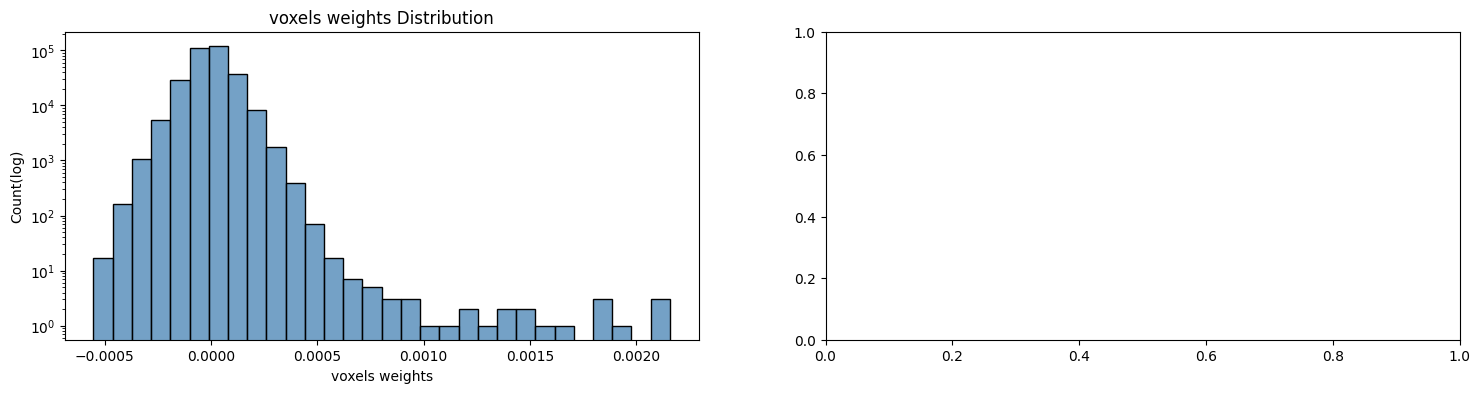

In [15]:
fig_hist, hist_axes = plt.subplots(1, 2, figsize=(18, 4))

sns.histplot(voxel_space_weights, bins=30, ax=hist_axes[0], color="steelblue")
hist_axes[0].set(xlabel="voxels weights", ylabel="Count(log)", title="voxels weights Distribution")
hist_axes[0].set_yscale("log")

# sns.histplot(weights, bins=30, ax=hist_axes[1], color="steelblue")
# hist_axes[1].set(xlabel="comp weights", ylabel="Count", title="components weights Distribution")
# hist_axes[1].set_yscale("log")

# plt.suptitle("Weights Distribution", fontsize=16)
# plt.tight_layout()

Text(0.5, 1.0, 'reconstructed Y')

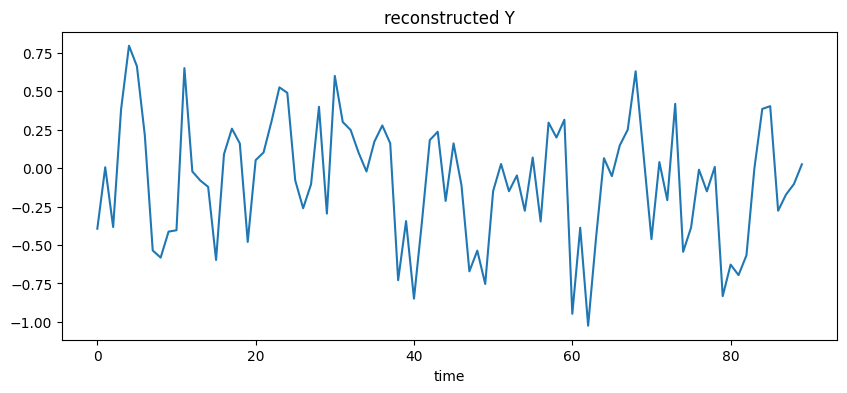

In [16]:
plt.figure(figsize=(10, 4))
plt.plot(y)
plt.xlabel("time")
plt.title("reconstructed Y")

In [ ]:
weight_vol = np.zeros(bold_data.shape[:3], dtype=np.float32)
active_coords_kept = tuple(coord[active_keep_mask] for coord in active_coords)
weight_vol[active_coords_kept] = np.abs(voxel_space_weights)

# lowe, upper = 0.0004, 0.002
# mask = (weight_vol >= lowe) & (weight_vol <= upper)
# weight_vol = np.where(mask, weight_vol, np.nan)
weight_vol = np.clip(weight_vol, None, 0.0004)

weight_img = nib.Nifti1Image(weight_vol, bold_img.affine)
weight_img_resamp = resample_to_img(weight_img, anat_img, interpolation="continuous")

view = plotting.view_img(
    weight_img_resamp,
    bg_img=anat_img,
    # threshold=np.percentile(voxel_space_weights, 95),
    # threshold=0.0,
    symmetric_cmap=False,
    cmap="jet",
    draw_cross=False,
    colorbar=True,
)
view.save_as_html(file_name=f'weights_map_{s1}_{s2}_energy_grad.html')

In [ ]:
voxel_space_weights = np.load(f'/home/zkavian/Thesis_code_Glm_Opt/voxel_space_weights_sub04_ses1_run1.npy')
data.shape

Corr between Y & Behaviour

In [42]:
# path = "/mnt/TeamShare/Data_Masterfile/H20-00572_All-Dressed/PRECISIONSTIM_PD_Data_Results/Behaviour/PSPD004/PSPD004_OFF_Run_1.mat"
# import h5py
# with h5py.File(path, 'r') as f:
#     behav_data = {key: np.array(f[key]) for key in f.keys()}

# squeeze_time = behav_data['squeeze_during_go_x_matrix'] #squeeze_time.shape
# squeeze_time = np.reshape(squeeze_time, (90, squeeze_time.shape[-1]))
# squeeze_time_var = np.var(squeeze_time, axis=1)

# y_reshaped = np.reshape(y, (90, 9))
# # y_reshaped_var = np.var(y_reshaped, axis=1)
# from scipy.stats import pearsonr

# r, p = pearsonr(y_reshaped_var, squeeze_time_var)
# print(f"Pearson correlation: r={r}, p-value={p}")

In [91]:
path = "/mnt/TeamShare/Data_Masterfile/H20-00572_All-Dressed/AllDressed_WorkOnData/Sepideh/Behaviour_metrics_revised/PSPD004_OFF_behav_metrics.mat"
from scipy.io import loadmat
import numpy as np

def load_behavior_metrics(path):
    behav_data = loadmat(path)
    behav_metrics = behav_data["behav_metrics"]
    behav_block = np.stack(behav_metrics[0], axis=0)
    _, trials_per_epoch, num_metrics = behav_block.shape
    behav_flat = behav_block.reshape(-1, num_metrics)
    return behav_flat
behavior_matrix = load_behavior_metrics(path)

In [85]:
behavior_matrix.shape

(180, 12)

In [92]:
path = "/mnt/TeamShare/Data_Masterfile/H20-00572_All-Dressed/AllDressed_WorkOnData/Sepideh/Behaviour_metrics_revised/PSPD004_OFF_behav_metrics.mat"

from scipy.io import loadmat
from scipy.stats import pearsonr

behav_data = loadmat(path)
behav_data = behav_data['behav_metrics']

behav_block = np.stack(behav_data[0], axis=0)
num_epochs, num_trials, num_metrics = behav_block.shape
behav_flat = behav_block.reshape(num_epochs * num_trials, num_metrics)

metric_names = ("PT", "RT", "MT", "RT+MT", "Vmax", "Pmax")
metrics = {name: behav_flat[:90, idx] for idx, name in enumerate(metric_names)}

for name, values in metrics.items():
    mask = np.isfinite(values) & np.isfinite(y)
    cleaned_y = y[mask]
    cleaned_vals = values[mask]

    r, p = pearsonr(cleaned_y, cleaned_vals)
    print(f"{name}: r={r:.3f}, p={p:.3g}")



PT: r=-0.074, p=0.536
RT: r=-0.068, p=0.569
MT: r=0.092, p=0.444
RT+MT: r=0.047, p=0.694
Vmax: r=-0.185, p=0.119
Pmax: r=-0.196, p=0.0982


In [69]:
cleaned_y.shape

(0,)

In [40]:
data = np.load('/home/zkavian/Thesis_code_Glm_Opt/behavior_penalty_components.npy')
data.shape

(588,)

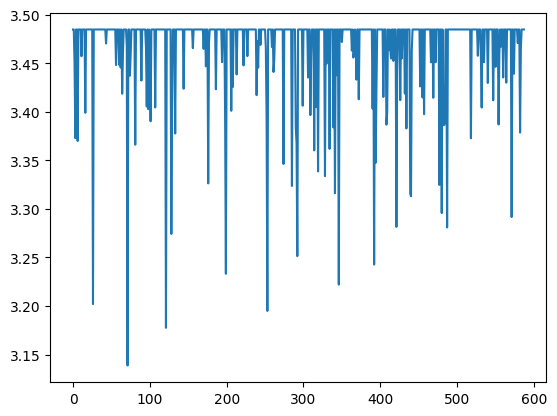

In [41]:
plt.plot(data)